### YOLO modeling

after testing the fealability of using pose estimators I now move to a newer model one that can support video anylsis better then the MPI heatmap-appraoch models

In [ ]:
import torch
import numpy as np
import cv2
import ultralytics

print(f"✅ NumPy: {np.__version__}")       # Expect 1.26.x
print(f"✅ OpenCV: {cv2.__version__}")     # Expect 4.10.x
print(f"🚀 GPU Active: {torch.backends.mps.is_available()}")
print(ultralytics.__version__)                # Expect 8.2.0+

✅ NumPy: 1.26.4
✅ OpenCV: 4.10.0
🚀 GPU Active: False
8.3.241


In [ ]:
# Helpers 
from typing import List, Union
import matplotlib.pyplot as plt
def show_image(img_or_list: Union[np.ndarray, List[np.ndarray]], row_plot: int = 1, titles: List[str] = None):
    """
    Display one or multiple images in a grid.
    - img_or_list: single array or list of arrays
    - row_plot: number of rows
    - titles: optional list of titles (same length as images)
    """
    imgs = img_or_list if isinstance(img_or_list, list) else [img_or_list]
    n = len(imgs)
    cols = int(np.ceil(n / row_plot))
    rows = row_plot

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = np.array(axes).reshape(-1) if isinstance(axes, np.ndarray) else np.array([axes])

    for i, im in enumerate(imgs):
        if im.ndim == 2:
            axes[i].imshow(im, cmap='gray')
        else:
            axes[i].imshow(im)
        axes[i].axis('off')
        if titles is not None and i < len(titles):
            axes[i].set_title(titles[i])
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()



### Downloading the Model

In [ ]:
from ultralytics import YOLO # type: ignore

# 1. Load the model (YOLO11 is the 2025 standard)
model = YOLO('yolo11n-pose.pt') 

# Social Synchrony

Social synchrony is operationalized as temporal coordination in movement between two interacting individuals. To quantify this coordination, we first transform pose trajectories into motion-based signals that reflect how body parts move over time - Velocity.

Synchrony metrics are then computed on these motion signals rather than on raw joint positions. The primary metric examined is the *cross-correlation* between the velocity time series of the dyad, which captures the degree to which changes in movement speed are temporally aligned between partners.


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

# Signal processing + stats
from scipy.signal import savgol_filter, correlate
from scipy.stats import pearsonr

from ultralytics import YOLO # type: ignore

# -----------------------------
# User config 
# -----------------------------
VIDEO_PATH = "./images/pope_and_bibi.mp4"     # <-- change
MODEL_WEIGHTS = "yolov8n-pose.pt" # or yolov8s-pose.pt for stronger results
CONF_THRES = 0.25
IOU_THRES  = 0.5

# Rolling window for synchrony (in seconds)
ROLL_WIN_SEC = 2.0

# Max lag for cross-correlation (in seconds)
MAX_LAG_SEC = 7.0

# Joint groups (COCO-17 indices; adjust if your model differs)
# COCO keypoints order (common): 
class BodyPart:
    nose = 0
    l_eye = 1
    r_eye = 2
    l_ear = 3
    r_ear = 4
    l_shoulder = 5
    r_shoulder = 6
    l_elbow = 7
    r_elbow = 8
    l_wrist = 9
    r_wrist = 10
    l_hip = 11
    r_hip = 12
    l_knee = 13
    r_knee = 14
    l_ankle = 15
    r_ankle = 16

body_part = BodyPart()
UPPER_BODY = [5, 6, 7, 8, 9, 10]  # shoulders, elbows, wrists
TORSO      = [11, 12, 5, 6]       # hips + shoulders
LOWER_BODY = [13, 14, 15, 16]     # knees, ankles


### Loading the video 

since I want to asses synchrony I have you know the fps of the video processer in order for me to accurantly define what I consider to be a synchrenize movement. 


In [ ]:
# --- Chunk 1: Video I/O + FPS ---

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise RuntimeError("Could not open video.")

fps = cap.get(cv2.CAP_PROP_FPS)
if fps is None or fps <= 1e-6:
    # Fallback if metadata missing
    fps = 30.0

dt = 1.0 / fps
print(f"FPS={fps:.3f}  dt={dt:.4f}s")


FPS=29.970  dt=0.0334s


The videoCapture function process around 30 frames per second, and alternativley every frame is 0.333 second interval from the previous one. 

Next, we would prcess the video through the YOLO model

In [ ]:
model = YOLO(MODEL_WEIGHTS)


output_path = "./data_output/bibi_and_pope_skeleton.mp4"
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # type: ignore


# We'll store raw estimators per frame in a list.
# Each item: a list of estimators, where estimator = (bbox_xyxy, kpts_xy, kpts_conf)
raw_estimators: List[List[Tuple[np.ndarray, np.ndarray, np.ndarray]]] = []


# Stuff for Video I/O

cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
if fps is None or fps <= 0:
    fps = 30.0  # fallback (important!)
frame_idx = 0
    # add a video writer to fetch the skelaton video
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# starting the every frame processing: 
while True:
    ret, frame = cap.read()
    
    if not ret:
        break
    


    # Run pose prediction
    # Note: model(frame) returns a Results list (usually len 1 for one image)

    # before passing the frame into the model I want to have a filter to improve the quality:
    blurred_frame = cv2.GaussianBlur(frame, (7, 7), 1.0)
    high_freq = cv2.subtract(frame.astype(float), blurred_frame.astype(float))
    alpha = 1.5
    sharpened = frame.astype(float) + alpha * high_freq
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
        
    results = model.predict(
        source=sharpened,
        conf=CONF_THRES,
        iou=IOU_THRES,
        verbose=False
    )

    dets_this_frame = []
    r0 = results[0]

    # r0.boxes.xyxy -> Nx4
    # r0.keypoints.xy -> NxKx2
    # r0.keypoints.conf -> NxK
    if r0.keypoints is not None and len(r0.keypoints) > 0:
        boxes_xyxy = r0.boxes.xyxy.cpu().numpy() if r0.boxes is not None else None # type: ignore

        kpts_xy    = r0.keypoints.xy.cpu().numpy() # type: ignore

        kpts_conf  = r0.keypoints.conf.cpu().numpy()  # type: ignore

        n_people = kpts_xy.shape[0]
        for i in range(n_people):
            bbox = boxes_xyxy[i] if boxes_xyxy is not None else None
            dets_this_frame.append((bbox, kpts_xy[i], kpts_conf[i]))

    raw_estimators.append(dets_this_frame)

    annotated_frame = results[0].plot()

    if annotated_frame.shape[:2] != (frame_height, frame_width):
        annotated_frame = cv2.resize(annotated_frame, (frame_width, frame_height))
    if annotated_frame.dtype != np.uint8:
        annotated_frame = annotated_frame.astype(np.uint8)
    
    
    # write a video frame with skeleton

    out.write(annotated_frame)
    frame_idx += 1

cap.release()
out.release()
n_frames = len(raw_estimators)
times = np.arange(n_frames) * dt
print(f"Loaded {n_frames} frames of estimators.")


Loaded 1122 frames of estimators.


The next section is needed only if the video contains 2 people. In my case I know that the SRL labs have 3 videos for each interactione ( 1 video containing the both side of the dyad while the other 2 videos are capturing each individual seperately). therefore, the next chulk might come handy if i would use only the dyad video - although  I do intend to use all 3 videos.


the purpose of the next chulk enables the model to overcome of seeing the world in snapshots-  with it, the model understands a sequence. that means that since the video is divided into frames we need to form a way in which the model now that the person in frame(n ) and the person in frame(n+1) is the same person. basically a Name Tag phase.

### Identity tracking for dyads

First, let Understand whats this model yields: 
the first parameter is the frame index (remember that the model run 30 fps )and the second parameter is the Person. within each frame (element in the list) and person index theres 17 elements findicating the joint of the corresponding body part. 

In [ ]:
raw_estimators[1006][0] 

(array([     836.72,      145.12,      1206.2,      712.58], dtype=float32),
 array([[     945.86,       238.8],
        [     962.17,      221.83],
        [     945.36,         224],
        [     1009.6,      217.29],
        [     961.56,      218.37],
        [     1104.9,      287.94],
        [     939.18,      279.27],
        [     1165.4,      420.27],
        [     901.33,      385.45],
        [     1040.4,      464.74],
        [     937.16,      446.94],
        [     1089.1,      504.26],
        [     975.63,      491.16],
        [     1036.6,      576.39],
        [     892.49,         557],
        [     1067.9,      717.17],
        [     946.64,      692.27]], dtype=float32),
 array([    0.93396,     0.91325,     0.57721,     0.88553,     0.12725,     0.99413,     0.95365,     0.98811,     0.87681,      0.9789,     0.86981,     0.98502,     0.96666,     0.88899,     0.77892,     0.42634,     0.31517], dtype=float32))

In [ ]:
# Helpers for tracking
import numpy as np
from typing import List, Tuple, Optional


#bbox_centroid-  compute centroid from bbox - each box represents [x1,y1,x2,y2] which are the top-left and bottom-right corners
# each box is a person detected in the frame
def bbox_centroid(bbox_xyxy: np.ndarray) -> np.ndarray:
    """Compute centroid from [x1,y1,x2,y2]."""
    x1, y1, x2, y2 = bbox_xyxy
    return np.array([(x1 + x2) / 2.0, (y1 + y2) / 2.0], dtype=float)
#----------------------------

#bbox_area- compute area from bbox
def bbox_area(bbox_xyxy: np.ndarray) -> float:
    """Compute area of bounding box."""
    x1, y1, x2, y2 = bbox_xyxy
    return max(0.0, x2 - x1) * max(0.0, y2 - y1)
#----------------------------
# Greedy assignment function - assigns detected people in current frame to those in previous frame based on centroid distances
def greedy_assign(prev_centroids: List[np.ndarray],
                  curr_centroids: List[np.ndarray]) -> List[Optional[int]]:
    """
    Greedy assignment: returns mapping from prev index -> curr index (or None).
    """
    if len(prev_centroids) == 0 or len(curr_centroids) == 0:
        return [None] * len(prev_centroids)

    # Distance matrix (prev x curr)
    D = np.zeros((len(prev_centroids), len(curr_centroids)), dtype=float)
    for i, pc in enumerate(prev_centroids):
        for j, cc in enumerate(curr_centroids):
            D[i, j] = np.linalg.norm(pc - cc)

    assigned_curr = set()
    mapping = [None] * len(prev_centroids)

    for _ in range(min(len(prev_centroids), len(curr_centroids))):
        # Find the global minimum distance remaining in D
        i, j = np.unravel_index(np.argmin(D), D.shape)
        if D[i, j] == np.inf:
            break
            
        mapping[i] = j 
        assigned_curr.add(j)
        # "Remove" this row and column from future consideration
        D[i, :] = np.inf
        D[:, j] = np.inf

    return mapping # pyright: ignore[reportReturnType]


First let's create an empty list catch the raw_estimators for 2 persons given that the input would include a dyad so no need to over-complecate it. 

In [ ]:

# --- Tracking two main subjects (IDs 0 and 1) ---
# 1. Initialize data containers
K = 17 # number of keypoints
n_frames = len(raw_estimators)
tracks = {
    0: {"kpts_xy": np.full((n_frames, K, 2), np.nan, dtype=float),
        "kpts_conf": np.full((n_frames, K), np.nan, dtype=float)},
    1: {"kpts_xy": np.full((n_frames, K, 2), np.nan, dtype=float),
        "kpts_conf": np.full((n_frames, K), np.nan, dtype=float)},
}

# palceholder for the  frame centroids


{0: {'kpts_xy': array([[[        nan,         nan],
          [        nan,         nan],
          [        nan,         nan],
          ...,
          [        nan,         nan],
          [        nan,         nan],
          [        nan,         nan]],
  
         [[        nan,         nan],
          [        nan,         nan],
          [        nan,         nan],
          ...,
          [        nan,         nan],
          [        nan,         nan],
          [        nan,         nan]],
  
         [[        nan,         nan],
          [        nan,         nan],
          [        nan,         nan],
          ...,
          [        nan,         nan],
          [        nan,         nan],
          [        nan,         nan]],
  
         ...,
  
         [[        nan,         nan],
          [        nan,         nan],
          [        nan,         nan],
          ...,
          [        nan,         nan],
          [        nan,         nan],
          [        nan,

then  I would find the FIRST frame that actually contains a detection


In [ ]:



first_valid_idx = None
for i, frame_dets in enumerate(raw_estimators):
    if len(frame_dets) > 0:
        first_valid_idx = i
        break

if first_valid_idx is None:
    raise RuntimeError("No detections found in any frame. Check your video or CONF_THRES.")

print(f"Starting tracking from frame index: {first_valid_idx}")


Starting tracking from frame index: 0


In [ ]:

# 3. Initialize IDs 0 and 1 from that first valid frame (by largest area)

first_frame_dets = raw_estimators[first_valid_idx]


# Sort by area so the main subjects get IDs 0 and 1 - the largest two bboxes 
first_sorted = sorted(first_frame_dets, key=lambda d: bbox_area(d[0]) if d[0] is not None else 0, reverse=True)



# Assign to tracks - getting the condinate of the first frame identified of the 2 peson and STORE by SIZE
# arranging the first_sorted(which is raw_estimetors) so that the "0" would be the one how is the larger box in the 
#first frame identified with people

# so here we have the keypoints of the first frame identified of the 2 peson and STORE by SIZE
for pid in [0, 1]:
    if pid < len(first_sorted):
        bbox, kxy, kcf = first_sorted[pid]
        tracks[pid]["kpts_xy"][first_valid_idx] = kxy
        tracks[pid]["kpts_conf"][first_valid_idx] = kcf





Now with the heavy lifting; It plays the video forward and ensures that "Person 0" in Frame 10 remains "Person 0" in Frame 11, even if they move.


In [ ]:

# 4. Main Tracking Loop

for t in range(first_valid_idx + 1, n_frames): # It starts exactly one frame after your "Casting" frame and runs until the end of the video.
    dets = raw_estimators[t]
    if not dets:
        continue

    # Prepare previous centroids for matching
    prev_centroids = []
    prev_valid_pids = []

    # The "Memory" Phase (Where were they?):
    for pid in [0, 1]:
        # Get last known position from the tracks we are building
        last_kpts = tracks[pid]["kpts_xy"][t-1]
        if not np.all(np.isnan(last_kpts)):
            # Use the bounding box of the keypoints as the centroid
            x1, y1 = np.nanmin(last_kpts[:, 0]), np.nanmin(last_kpts[:, 1])
            x2, y2 = np.nanmax(last_kpts[:, 0]), np.nanmax(last_kpts[:, 1])
            prev_centroids.append(np.array([(x1+x2)/2, (y1+y2)/2]))
            prev_valid_pids.append(pid)

    # Prepare current detections
    curr_bboxes = [d[0] for d in dets if d[0] is not None]
    curr_centroids = [bbox_centroid(b) for b in curr_bboxes]

    if not curr_centroids or not prev_centroids:
        # Fallback: if matching fails, just assign first available detections
        for pid in [0, 1]:
            if pid < len(dets):
                _, kxy, kcf = dets[pid]
                tracks[pid]["kpts_xy"][t] = kxy
                tracks[pid]["kpts_conf"][t] = kcf
        continue

    # Match previous frame people to current frame people
    mapping = greedy_assign(prev_centroids, curr_centroids)

    used_det_indices = set()
    for i, j in enumerate(mapping):
        if j is None: continue
        
        pid = prev_valid_pids[i]
        target_bbox = curr_bboxes[j]
        
        # Find which detection index in 'dets' this belongs to
        for di, d in enumerate(dets):
            if d[0] is not None and np.allclose(d[0], target_bbox) and di not in used_det_indices:
                used_det_indices.add(di)
                _, kxy, kcf = d
                tracks[pid]["kpts_xy"][t] = kxy
                tracks[pid]["kpts_conf"][t] = kcf
                break

print("Tracking done (dyad IDs: 0 and 1).")




Tracking done (dyad IDs: 0 and 1).


now we have  tracks object is a dictionary type containing two main matrices for each person - keypooint and confidance.
If my video is 30 seconds long at 30 FPS, you have 900 rows of data. every row is a frmae

kpts_xy:
    Rows: Frame Number (Time).
    Columns: Body Part (Nose, Left Eye, Right Shoulder, etc.).
    The values are the coordinates $(x, y)$.
kpts_conf:
    Rows: Frame Number (Time).
    Columns: Body Part (Nose, Left Eye, Right Shoulder, etc.).
    the value is a single number (0.0 to 1.0) representing how "confident" the model is



In [ ]:
pid = 1  # Check Person 0
print(f"--- Structure for Person {pid} ---")
print(f"XY Shape:   {tracks[pid]['kpts_xy'].shape}  -> (Frames, Joints, 2)")
print(f"Conf Shape: {tracks[pid]['kpts_conf'].shape} -> (Frames, Joints)")

# Example: Get the Nose (index 0) position at the last frame
last_frame = tracks[pid]['kpts_xy'].shape[0] - 5
l_elbow_pos_last_frame = tracks[pid]['kpts_xy'][last_frame, body_part.l_elbow] # what is index 4 

print(f"left Elbow at last frame: {l_elbow_pos_last_frame}")

--- Structure for Person 1 ---
XY Shape:   (1122, 17, 2)  -> (Frames, Joints, 2)
Conf Shape: (1122, 17) -> (Frames, Joints)
left Elbow at last frame: [     812.56      425.98]


## Preprocessing- data handling and noise reduction 
Now lets deal with noise and uncertainty 


In [ ]:
# Helpers for cleaning keypoints
#apply_conf_mask - takes the minimun threshold given as an arguemnt and assign NaN to kpts_xy where the codition isn't met
def apply_conf_mask(kpts_xy: np.ndarray, kpts_conf: np.ndarray, conf_min: float = 0.3) -> np.ndarray:
    """Set (x,y) to NaN where confidence < conf_min."""
    out = kpts_xy.copy()
    bad = (kpts_conf < conf_min) | np.isnan(kpts_conf)
    out[bad, :] = np.nan
    return out



def interp_nan_1d(y: np.ndarray, max_gap: int = 10) -> np.ndarray:
    """
    Interpolate NaNs in a 1D array; only fill gaps <= max_gap.
    """
    y2 = y.copy()# Work on a copy so we don't change the original data by accident
    n = len(y2) # How long is the data?
    idx = np.arange(n)# Create an index: [0, 1, 2, 3, ... n-1]

    nan_mask = np.isnan(y2) #This creates a "mask" (True/False list):
    #True: The value is missing (NaN). 
    # False: The value is real (e.g., 0.95).

    if nan_mask.all():
        return y2 # this check if the y2 pbject is ALL NaN 

    
    # Interpolate all NaNs first
    y2[nan_mask] = np.interp(idx[nan_mask], idx[~nan_mask], y2[~nan_mask]) # take the indexes of the NaN values and replace them with interpolated values from the non-NaN values (the)
    # 1st arg (x): The "Questions" -> The Frame numbers (indices) where data is MISSING. - idx[nan_mask]
    # 2nd arg (xp): The "X-Ref" -> The Frame numbers where we HAVE valid data. - idx[~nan_mask]
    # 3rd arg (fp): The "Y-Ref" -> The actual values at those valid frames. - y2[~nan_mask]

    
    # Find consecutive NaN runs in original

    runs = []
    start = None
    for i in range(n):
        if nan_mask[i] and start is None:
            start = i
        if (not nan_mask[i]) and start is not None:
            runs.append((start, i-1))
            start = None
    if start is not None:
        runs.append((start, n-1))

    for a, b in runs:
        if (b - a + 1) > max_gap:
            y2[a:b+1] = np.nan

    return y2

def smooth_1d(y: np.ndarray, window: int = 11, poly: int = 2) -> np.ndarray:
    """
    Savitzky-Golay smoothing, safe with NaNs (smooth only the valid part).
    """
    y2 = y.copy()
    valid = ~np.isnan(y2)
    if valid.sum() < window:
        return y2
    y2[valid] = savgol_filter(y2[valid], window_length=window, polyorder=poly)
    return y2


In [ ]:

# Clean each person, each joint, both x and y
CONF_THER= 0.3
MAX_GAP_FRAMES = int(0.3 * fps)  # fill up to ~300ms gaps

clean_xy = {}
for pid in [0, 1]:
    xy = tracks[pid]["kpts_xy"]          # (T,K,2)
    cf = tracks[pid]["kpts_conf"]        # (T,K)

    # Apply confidence mask frame-by-frame
    xy_masked = np.full_like(xy, np.nan)
    for t in range(n_frames):
        xy_masked[t] = apply_conf_mask(xy[t], cf[t], conf_min=CONF_THER)

    # Interpolate + smooth per joint, per coordinate over time
    xy_filt = xy_masked.copy()
    for j in range(K):
        for c in [0, 1]:  # x,y
            series = xy_masked[:, j, c]
            series = interp_nan_1d(series, max_gap=MAX_GAP_FRAMES)
            series = smooth_1d(series, window=11, poly=2)
            xy_filt[:, j, c] = series

    clean_xy[pid] = xy_filt

print("Keypoints cleaned (confidence mask + interpolation + smoothing).")

# what is clean_xy 


Keypoints cleaned (confidence mask + interpolation + smoothing).


`clean_xy` is the cleaned pose time-series that we carry forward for all synchrony analyses. It contains the estimated (x, y) coordinates of each joint for each tracked person at every frame, after low-confidence detections were removed, short gaps were interpolated, and frame-to-frame jitter was smoothed.

 From this point on, we do **not** work with raw YOLO outputs anymore—`clean_xy` is treated as our best estimate of true body motion. 
 
 Because social synchrony is defined in terms of **coordinated movement over time** rather than static posture or absolute position, the next step is to transform `clean_xy` into motion signals (e.g., joint velocity magnitudes) that capture how each body part moves from frame to frame.


The function `velocity_magnitude()` transforms joint positions over time into a one-dimensional motion signal by computing frame-to-frame velocity. 

For each time point, it estimates horizontal and vertical velocity components using finite differences and combines them into a single scalar velocity magnitude. This representation captures how fast a joint is moving regardless of direction, making it well-suited for comparing movement dynamics between individuals and for computing synchrony metrics. Missing values are propagated to avoid introducing spurious motion.


In [ ]:
# --- Chunk 5: Pose -> motion signals (velocity magnitude) ---

def velocity_magnitude(xy: np.ndarray, dt: float) -> np.ndarray:
    """
    xy: (T,2) joint coordinates over time
    returns v: (T,) velocity magnitude, NaN where insufficient data
    """
    v = np.full((xy.shape[0],), np.nan, dtype=float)
    # Finite difference: v[t] based on xy[t] - xy[t-1]
    for t in range(1, xy.shape[0]):
        if np.any(np.isnan(xy[t])) or np.any(np.isnan(xy[t-1])):
            continue
        dx = (xy[t, 0] - xy[t-1, 0]) / dt
        dy = (xy[t, 1] - xy[t-1, 1]) / dt
        v[t] = np.sqrt(dx*dx + dy*dy)
    return v

def group_velocity(clean_xy_pid: np.ndarray, joint_ids: List[int], dt: float) -> np.ndarray:
    """
    Compute per-joint velocity magnitude and average across the joint group.
    Output: (T,) group velocity signal.
    """
    all_v = []
    for j in joint_ids:
        vj = velocity_magnitude(clean_xy_pid[:, j, :], dt)
        all_v.append(vj)
    all_v = np.vstack(all_v)  # (len(joints), T)
    return np.nanmean(all_v, axis=0)


Although pose estimation provides joint-level data, synchrony was not analyzed independently for every individual body part. Joint-level signals are inherently noisy, frequently affected by occlusion, and yield highly correlated time series across neighboring joints (e.g., wrist–elbow–shoulder). Analyzing each joint separately would therefore substantially increase the number of statistical tests without providing independent information, inflating false-positive risk and reducing interpretability.


Instead, joints were grouped into anatomically and functionally meaningful regions (upper body, torso, lower body), which improves signal-to-noise ratio, preserves statistical power, and yields synchrony measures that are more stable and theoretically interpretable at the interaction level.
 
Joint-wise analyses can be conducted as exploratory or supplementary analyses, but region-level aggregation is more appropriate for primary inference.

Therefore, the mean of every body part's velocity within each group would the the metric  


/var/folders/d9/swb4gsnx7p564yccbz0s91d80000gp/T/ipykernel_85558/3708913769.py:28: RuntimeWarning: Mean of empty slice
  return np.nanmean(all_v, axis=0)


Motion signals extracted: upper/torso/lower velocity magnitudes.


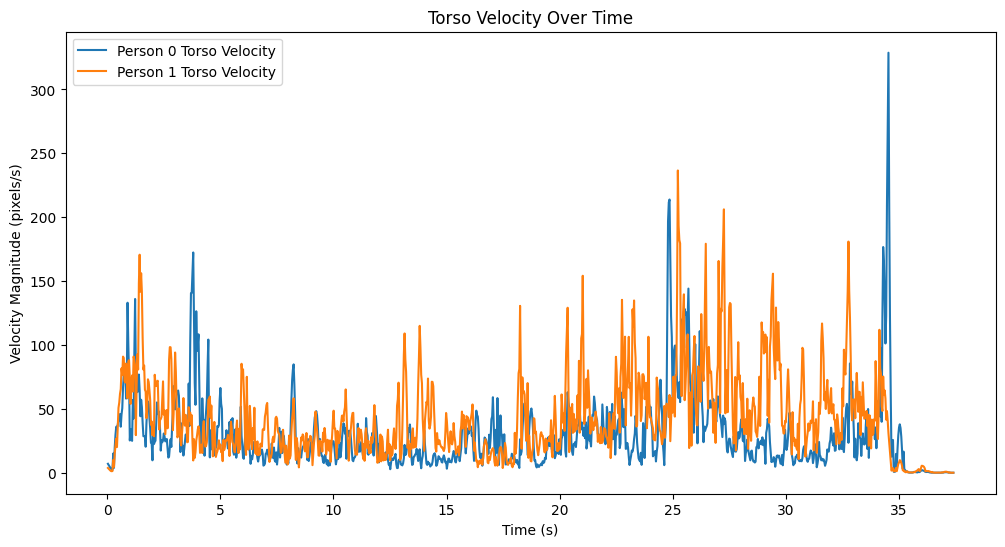

In [ ]:

Body_Parts_Group_Velocity = {}
for pid in [0, 1]:
    Body_Parts_Group_Velocity[pid] = {
        "upper_v": group_velocity(clean_xy[pid], UPPER_BODY, dt),
        "torso_v": group_velocity(clean_xy[pid], TORSO, dt),
        "lower_v": group_velocity(clean_xy[pid], LOWER_BODY, dt),
    }

print("Motion signals extracted: upper/torso/lower velocity magnitudes.")
# Example: Plot torso velocity for both persons
plt.figure(figsize=(12, 6))
plt.plot(times, Body_Parts_Group_Velocity[0]["torso_v"], label="Person 0 Torso Velocity")
plt.plot(times, Body_Parts_Group_Velocity[1]["torso_v"], label="Person 1 Torso Velocity")
plt.xlabel("Time (s)")
plt.ylabel("Velocity Magnitude (pixels/s)")
plt.title("Torso Velocity Over Time")
plt.legend()

After establishing  a quantifiable measure for movement it's time to constract out first metric: cross-correlation with lag (correlation between Person A and Person B motion signals while shifting time (lag)).



In [ ]:
# Helper functions for cross-correlation analysis
def zscore_nan(x: np.ndarray) -> np.ndarray:
    """Z-score while ignoring NaNs."""
    x2 = x.copy()
    m = np.nanmean(x2)
    s = np.nanstd(x2)
    if np.isnan(m) or np.isnan(s) or s < 1e-8:
        return x2 * np.nan
    return (x2 - m) / s

def lagged_corr(x: np.ndarray, y: np.ndarray, max_lag_frames: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute correlation r(lag) for lags in [-max_lag_frames, +max_lag_frames].
    Returns lags (frames) and correlations (r).
    """
    lags = np.arange(-max_lag_frames, max_lag_frames + 1)
    rs = np.full_like(lags, np.nan, dtype=float)

    for i, lag in enumerate(lags):
        if lag < 0:
            x_seg = x[-lag:]
            y_seg = y[:len(y)+lag]
        elif lag > 0:
            x_seg = x[:len(x)-lag]
            y_seg = y[lag:]
        else:
            x_seg = x
            y_seg = y

        # Mask NaNs pairwise
        mask = ~np.isnan(x_seg) & ~np.isnan(y_seg)
        if mask.sum() < 10:
            continue

        r, _ = pearsonr(x_seg[mask], y_seg[mask])
        rs[i] = r

    return lags, rs

def summarize_lagged_sync(x: np.ndarray, y: np.ndarray, fps: float, max_lag_sec: float) -> Dict[str, float]:
    max_lag_frames = int(max_lag_sec * fps)
    xz = zscore_nan(x)
    yz = zscore_nan(y)

    lags, rs = lagged_corr(xz, yz, max_lag_frames=max_lag_frames)

    if np.all(np.isnan(rs)):
        return {"max_r": np.nan, "lag_sec": np.nan}

    best_i = np.nanargmax(rs)
    best_lag_frames = lags[best_i]
    return {"max_r": float(rs[best_i]), "lag_sec": float(best_lag_frames / fps)}

In [ ]:

# Example: upper-body synchrony
sync_upper = summarize_lagged_sync(Body_Parts_Group_Velocity[0]["upper_v"], Body_Parts_Group_Velocity[1]["upper_v"], fps=fps, max_lag_sec=MAX_LAG_SEC)
sync_torso = summarize_lagged_sync(Body_Parts_Group_Velocity[0]["torso_v"], Body_Parts_Group_Velocity[1]["torso_v"], fps=fps, max_lag_sec=MAX_LAG_SEC)
sync_lower = summarize_lagged_sync(Body_Parts_Group_Velocity[0]["lower_v"], Body_Parts_Group_Velocity[1]["lower_v"], fps=fps, max_lag_sec=MAX_LAG_SEC)

print("Lagged synchrony (max within ±lag):")
print("upper:", sync_upper)
print("torso:", sync_torso)
print("lower:", sync_lower)


Lagged synchrony (max within ±lag):
upper: {'max_r': 0.5427069867133023, 'lag_sec': 0.0}
torso: {'max_r': 0.30266748008142197, 'lag_sec': -0.10010000000000001}
lower: {'max_r': 0.41398075580228166, 'lag_sec': 0.46713333333333334}


Let's see if such correlation is significant using an a parametric test - Permutation.
I didn't chose t test since such test assumes independence whereas in an interaction one person movement effect and influance the other. 

Core idea of the permutation test:

* Keep each person’s movement intact

* Destroy interpersonal timing by shifting one signal in time

* Recompute the same statistic (max cross-correlation) many times

* Compare the real value to this null distribution

In [ ]:

def circular_shift(x: np.ndarray, shift: int) -> np.ndarray:
    """Circularly shift a 1D array by 'shift' frames."""
    return np.roll(x, shift) # basically we are taking a a random "person 1" frame and shifting it by "shift" frames to create a null distribution  where there is no synchrony between person 0 and him

def synchrony_null_distribution(x: np.ndarray, y: np.ndarray, fps: float, max_lag_sec: float,
                                n_perm: int = 500, min_shift_sec: float = 5.0) -> np.ndarray:
    """
    Build null distribution of max cross-corr by circularly shifting y.
    min_shift_sec prevents tiny shifts that preserve coupling.
    """
    max_lag_frames = int(max_lag_sec * fps)
    min_shift = int(min_shift_sec * fps)

    xz = zscore_nan(x)
    yz = zscore_nan(y)

    null_vals = np.full((n_perm,), np.nan, dtype=float) # building an empty array to fetch latter on the lagged_cor
    for i in range(n_perm):
        # sample a shift far enough away
        shift = np.random.randint(min_shift, len(yz) - min_shift)
        y_shift = circular_shift(yz, shift)

        _, rs = lagged_corr(xz, y_shift, max_lag_frames)
        null_vals[i] = np.nanmax(rs)

    return null_vals

def p_value_from_null(real_val: float, null_vals: np.ndarray) -> float:
    """One-sided p: probability null >= real."""
    null_vals = null_vals[~np.isnan(null_vals)]
    if len(null_vals) == 0 or np.isnan(real_val):
        return np.nan
    return float((np.sum(null_vals >= real_val) + 1) / (len(null_vals) + 1))



Let's check if H1 hypothesis is being supported!

In [ ]:
def apa_row(region_name, sync_dict, signal_a, signal_b):
    real_r = sync_dict["max_r"]

    null_vals = synchrony_null_distribution(
        signal_a,
        signal_b,
        fps=fps,
        max_lag_sec=MAX_LAG_SEC,
        n_perm=300,
        min_shift_sec=1.0
    )

    p_val = p_value_from_null(real_r, null_vals)

    return {
        "Body region": region_name,
        "Observed r": round(real_r, 2),
        "Null mean r": round(float(np.nanmean(null_vals)), 2),
        "p (perm)": round(p_val, 3)
    }

apa_table = pd.DataFrame([
    apa_row("Upper body", sync_upper, Body_Parts_Group_Velocity[0]["upper_v"], Body_Parts_Group_Velocity[1]["upper_v"]),
    apa_row("Torso",      sync_torso, Body_Parts_Group_Velocity[0]["torso_v"], Body_Parts_Group_Velocity[1]["torso_v"]),
    apa_row("Lower body", sync_lower, Body_Parts_Group_Velocity[0]["lower_v"], Body_Parts_Group_Velocity[1]["lower_v"]),
])

apa_table



,Body region,Observed r,Null mean r,p (perm)
0,Upper body,0.54,0.31,0.136
1,Torso,0.30,0.24,0.233
2,Lower body,0.41,0.22,0.302
